In this notebook we will attempt to learn how to construct and train a deep neural network from scratch to predict the handwritten digits. For this task we will perform the following:
- download and check the data
- prepare the dataset for training
- train the baseline model
- process to develop a better model
- analyze results

First, we import all the libraries we need:

In [1]:
!pip install -Uqq fastai

In [2]:
!pip install fastbook

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 16.7 MB/s eta 0:00:00


In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

from pathlib import Path

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets

# fastai
from fastai.vision.all import *
from fastbook import *

Nest, we define global variables and plot style:

In [4]:
# Plotting style
plt.style.use('ggplot')

# Global variables
DATA_DIR = Path('/kaggle/working/data/')

# About the dataset

## Download the dataset

To train anything we first need the data. For this project we will use the famous [MNIST dataset](https://pytorch.org/vision/stable/generated/torchvision.datasets.MNIST.html#torchvision.datasets.MNIST) comprised of images of digits from 0 to 9 where our task is to predict the digit based on the image provided. The dataset is already provided in the `dataset` module of `torchvision` library. To view which datasets are available see the [link](https://pytorch.org/vision/stable/datasets.html).

To download the dataset we need to provide the following arguments: `root`: where to save the downloaded files, `train`: should the train dataset be downloaded, and `download` whether to download the dataset. Note that if the data already exists locally in the provided `root` argument then the data will not be downloaded. The dataset will be processed as PyTorch `DataSet`.

In [5]:
data_train = datasets.MNIST(root=DATA_DIR, train=True, download=True)
data_test = datasets.MNIST(root=DATA_DIR, train=False, download=True)

print(f'Train data: {len(data_train)}')
print(f'Test data: {len(data_test)}')

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /kaggle/working/data/MNIST/raw/train-images-idx3-ubyte.gz to /kaggle/working/data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /kaggle/working/data/MNIST/raw/train-labels-idx1-ubyte.gz to /kaggle/working/data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /kaggle/working/data/MNIST/raw/t10k-images-idx3-ubyte.gz to /kaggle/working/data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /kaggle/working/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /kaggle/working/data/MNIST/raw

Train data: 60000
Test data: 10000


So in total there are 70000 images of handrwitten digits. Since the data is processed as PyTorch dataset then we know that each element of `data_train` is a tuple of inputs and labels. Let's see how some of them look like:

In [6]:
def show_sample(data):
    """Ref: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html"""
    fig = plt.figure(figsize=(7,7))
    cols, rows = 3,3
    for i in range(1, cols*rows+1):
        sample_idx = torch.randint(len(data), size=(1,)).item()
        # Get image and the corresponding label
        img, label = data[sample_idx]
        fig.add_subplot(rows,cols,i)
        plt.imshow(img, cmap='Blues')
        plt.title(f'Label: {label}', size=10)
        plt.axis("off")
    plt.show()

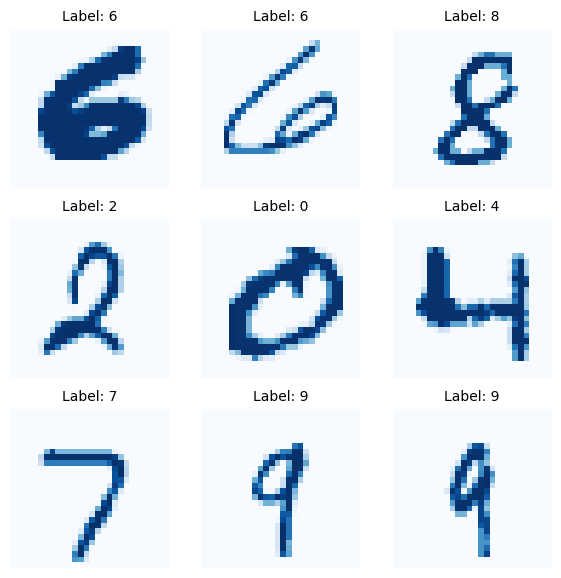

In [7]:
show_sample(data_train)

Each of the images is composed of pixels ranging from 0 to 255, where 0 represents white and 255 black. Let's see what we mean by that:

In [8]:
# Extract the first image and its label from the dataset
img, label = data_train[0]
print(f'Image dimension: {img.shape}')
print(f'Label: {label}')

Image dimension: (28, 28)
Label: 5


So the image size is 28 by 28 pixels and the first image should represent digit 5. Let's see the pixel data, which we will convert to tensors first. Then for better representation, we wrap the data with the dataframe and style it using the blue gradient. From the image below we can see that it does look like digit 5.

In [9]:
dfimg = pd.DataFrame(tensor(img))
dfimg.style.set_properties(**{'font-size':'6pt'}).background_gradient('Blues')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0,3,18,18,18,126,136,175,26,166,255,247,127,0,0,0,0
6,0,0,0,0,0,0,0,0,30,36,94,154,170,253,253,253,253,253,225,172,253,242,195,64,0,0,0,0
7,0,0,0,0,0,0,0,49,238,253,253,253,253,253,253,253,253,251,93,82,82,56,39,0,0,0,0,0
8,0,0,0,0,0,0,0,18,219,253,253,253,253,253,198,182,247,241,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,80,156,107,253,253,205,11,0,43,154,0,0,0,0,0,0,0,0,0,0


## Prepare dataset for training

# Training

## Define the device for training

We can train our model either on CPU or GPU whichever is available. To see what is available on the current computer we can run the following command:

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f'Using {device} device!')

Using cpu device!
